На базе баскетбольных матчей добейтесь средней абсолютной ошибки 17 и менее очков.

### Подготовка  

In [1]:
# Загрузка из google облака
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv', None, quiet=True)

# Библиотека для работы с базами
import pandas as pd
df = pd.read_csv('basketball.csv', encoding= 'cp1251', sep=';', header=0, index_col=0) # Загружаем базу
df.head()

,TOTAL,info,Ком. 1,Ком. 2,Минута,Общая минута,Секунда,fcount,ftime
0,"98,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,0.0,1,1.0,30,81,90.0
1,"100,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,1,1.0,45,81,105.0
2,"99,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,2,2.0,0,81,120.0
3,"98,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,2,2.0,30,81,150.0
4,"95,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,3,3.0,0,81,180.0


Извлекаем текстовые данные из колонки `info` таблицы, помещаем в переменную `data_text`. Выводим длину списка:

In [2]:
data_text = df['info'].values #

len(data_text) #

52450

Задаем максимальное кол-во слов в словаре, помещаем в переменную все символы, которые хотим вычистить из текста.

 Токенизируем текстовые данные:

In [3]:
# Импортируем токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

maxWordsCount = 5000

sim_for_del='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer (num_words=maxWordsCount,
                       filters=sim_for_del,
                       lower=True,
                       split=' ',
                       oov_token='unknown',
                       char_level=False)

tokenizer.fit_on_texts(data_text)

E0000 00:00:1746992573.930538   57631 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746992573.959264   57631 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Переводим в Эмбеддинг пространство
Sequences = tokenizer.texts_to_sequences(data_text)

# Вариант  Bag of Words
xBOW_text = tokenizer.sequences_to_matrix(Sequences)

Преобразуем данные в numpy, подготовим наборы для обучения:

In [5]:
# Библиотека работы с массивами
import numpy as np

xTrain = np.array(df[['Ком. 1','Ком. 2', 'Минута', 'Секунда','ftime']].astype('int'))
yTrain = np.array(df['fcount'].astype('int'))

In [6]:
print(xTrain.shape)
print(yTrain.shape)
print(xBOW_text.shape)

(52450, 5)
(52450,)
(52450, 5000)


In [7]:
import matplotlib.pyplot as plt

In [8]:
from tensorflow.keras.callbacks import LambdaCallback
# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    SpatialDropout1D,
    BatchNormalization,
    Embedding,
    Flatten,
    Activation,
    Input,
    concatenate,
)
from tensorflow.keras.layers import (
    SimpleRNN,
    GRU,
    LSTM,
    Bidirectional,
    Conv1D,
    MaxPooling1D,
    GlobalMaxPooling1D,
)

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [15]:
input1 = Input((xTrain.shape[1],))
input2 = Input((xBOW_text.shape[1],))

x1 = input1
x1 = BatchNormalization()(x1)
x1 = Dense(256, activation="relu")(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(128, activation="relu")(x1)
x1 = Dropout(0.3)(x1)


x2 = input2
x2 = Dense(256, activation="relu")(x2)
x2 = Dropout(0.4)(x2)
x2 = Dense(128, activation="relu")(x2)
x2 = Dropout(0.4)(x2)
x2 = Dense(64, activation="relu")(x2)
x2 = Dropout(0.4)(x2)

x = concatenate([x1, x2])

x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(1, activation="linear")(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(learning_rate=1e-3), loss="mse", metrics=["mae"])



In [ ]:
# Функция по проверке ошибки


def check_MAE_predictl_DubbleInput(
    model, x_data, x_data_text, y_data_not_scaled, plot=False
):
    mae = 0  # Инициализируем начальное значение ошибки
    y_pred = (model.predict([x_data, x_data_text])).squeeze()

    for n in range(0, len(x_data)):
        mae += abs(
            y_data_not_scaled[n] - y_pred[n]
        )  # Увеличиваем значение ошибки для текущего элемента
    mae /= len(x_data)  # Считаем среднее значение
    print(
        "Среднаяя абслолютная ошибка {:.3f} очков это {:.3f}% от общей выборки в {} игры".format(
            mae, (mae / y_data_not_scaled.mean(axis=0)) * 100, len(x_data)
        )
    )

    if plot:
        plt.scatter(y_data_not_scaled, y_pred)
        plt.xlabel("Правильные значение")
        plt.ylabel("Предсказания")
        plt.axis("equal")
        plt.xlim(plt.xlim())
        plt.ylim(plt.ylim())
        plt.plot([0, 250], [0, 250])
        plt.show()

In [11]:
def on_epoch_end_custom(epoch, logs=None):
    print("Эпоха:", epoch)
    check_MAE_predictl_DubbleInput(model,xTrain,xBOW_text,yTrain,plot=True)

pltMae = LambdaCallback(on_epoch_end=on_epoch_end_custom)

Эпоха: 0
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Среднаяя абслолютная ошибка 12.739 очков это 8.402% от общей выборки в 52450 игры


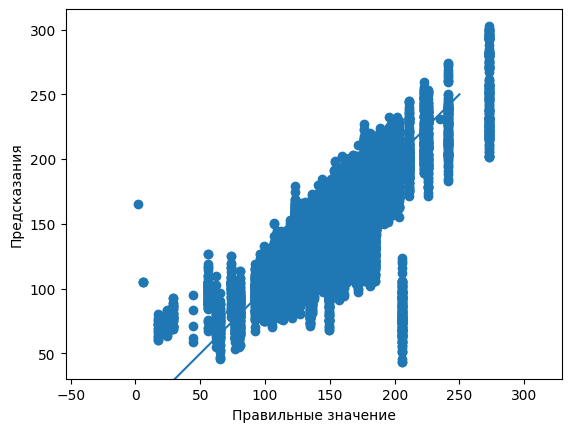

Эпоха: 1
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Среднаяя абслолютная ошибка 13.371 очков это 8.819% от общей выборки в 52450 игры


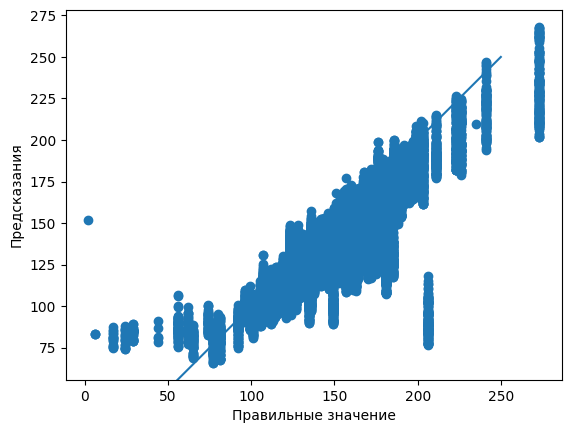

Эпоха: 2
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Среднаяя абслолютная ошибка 8.391 очков это 5.534% от общей выборки в 52450 игры


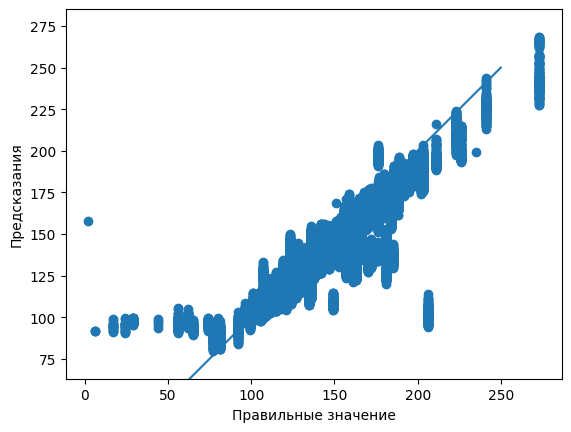

Эпоха: 3
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Среднаяя абслолютная ошибка 5.739 очков это 3.785% от общей выборки в 52450 игры


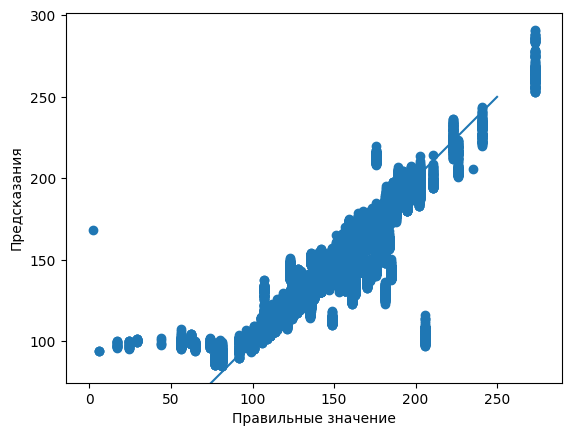

Эпоха: 4
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Среднаяя абслолютная ошибка 9.000 очков это 5.936% от общей выборки в 52450 игры


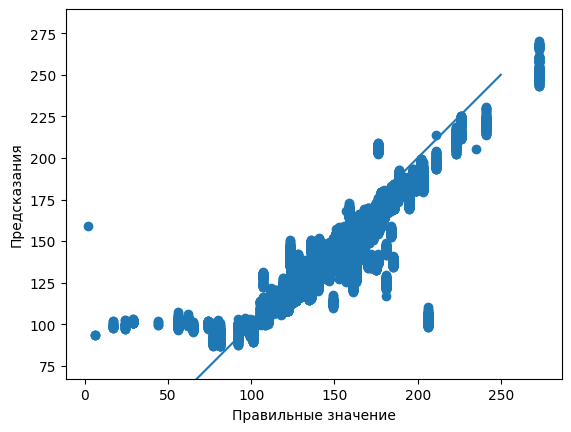

Эпоха: 5
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Среднаяя абслолютная ошибка 11.546 очков это 7.615% от общей выборки в 52450 игры


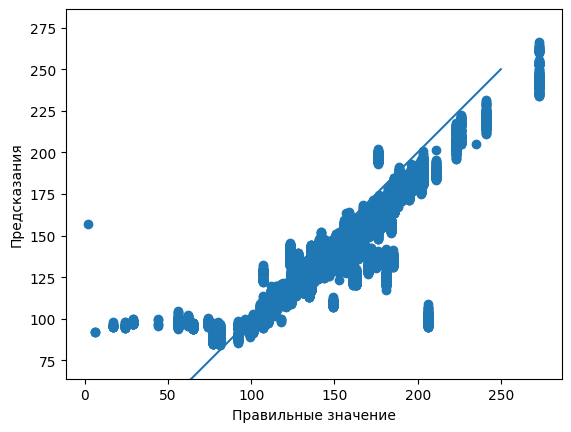

Эпоха: 6
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Среднаяя абслолютная ошибка 5.244 очков это 3.459% от общей выборки в 52450 игры


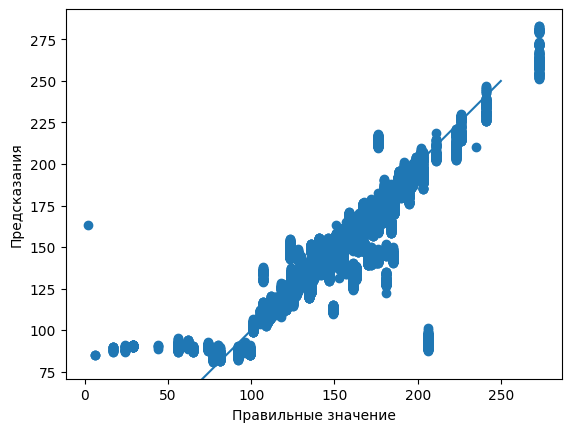

Эпоха: 7
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Среднаяя абслолютная ошибка 6.074 очков это 4.006% от общей выборки в 52450 игры


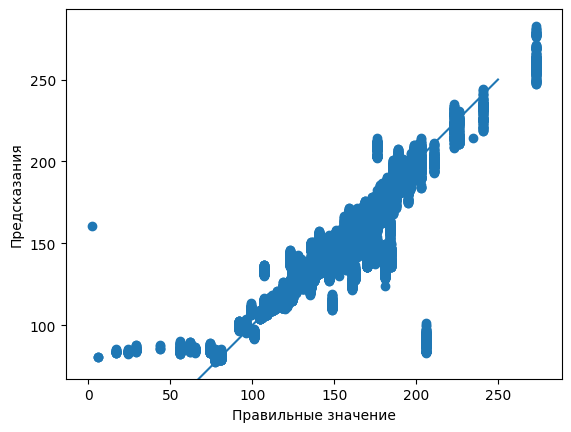

Эпоха: 8
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Среднаяя абслолютная ошибка 9.447 очков это 6.231% от общей выборки в 52450 игры


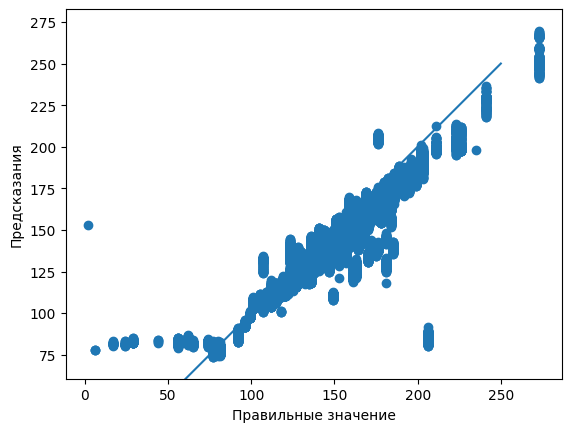

Эпоха: 9
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Среднаяя абслолютная ошибка 6.139 очков это 4.049% от общей выборки в 52450 игры


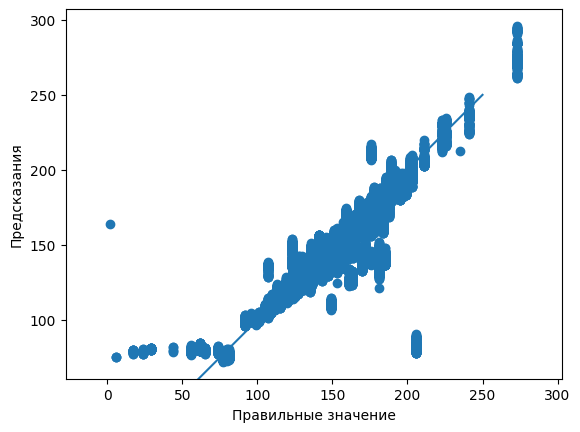

Эпоха: 10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Среднаяя абслолютная ошибка 5.402 очков это 3.563% от общей выборки в 52450 игры


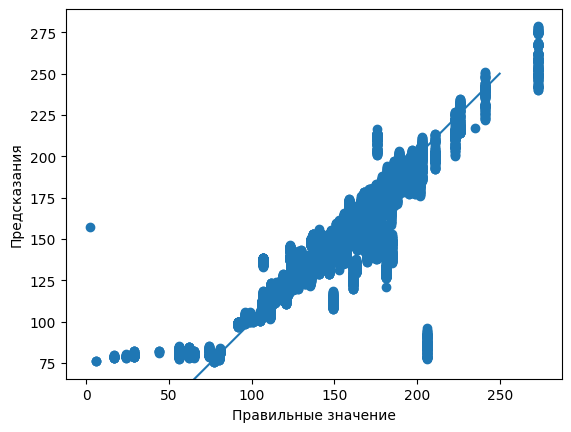

Эпоха: 11
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Среднаяя абслолютная ошибка 5.762 очков это 3.800% от общей выборки в 52450 игры


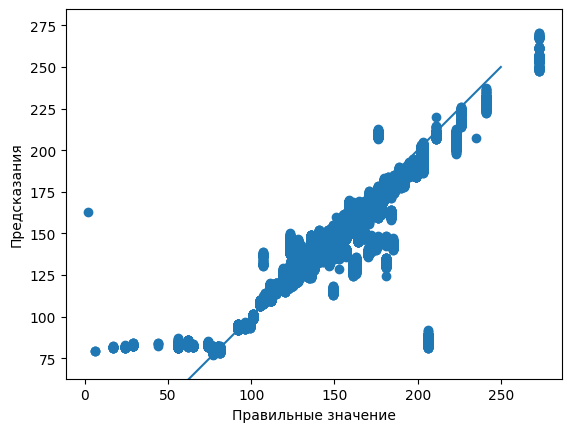

Эпоха: 12
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Среднаяя абслолютная ошибка 8.319 очков это 5.487% от общей выборки в 52450 игры


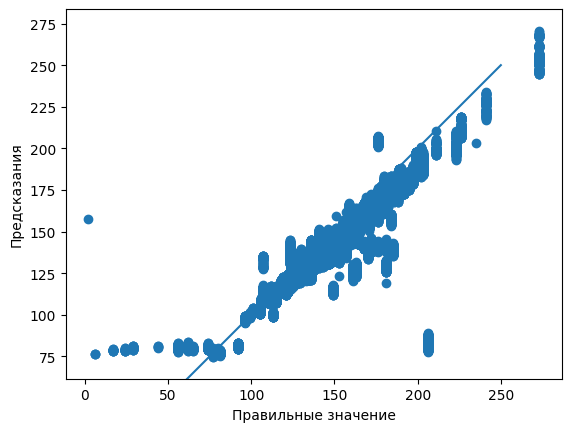

Эпоха: 13
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Среднаяя абслолютная ошибка 5.887 очков это 3.882% от общей выборки в 52450 игры


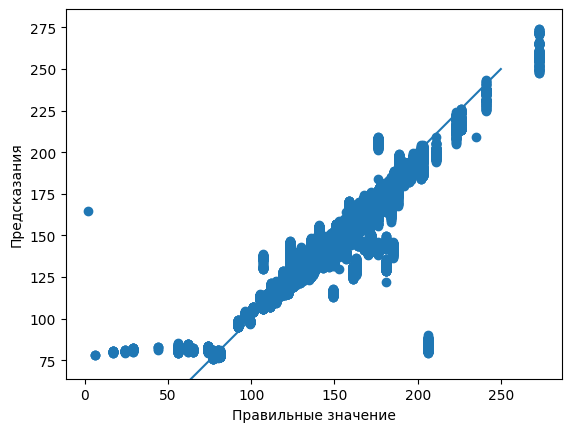

Эпоха: 14
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Среднаяя абслолютная ошибка 4.803 очков это 3.168% от общей выборки в 52450 игры


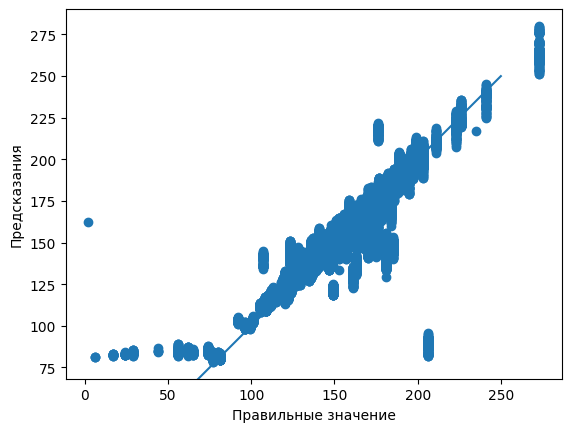

In [16]:
history = model.fit(
    [xTrain, xBOW_text],
    yTrain,
    batch_size=256,
    epochs=15,
    validation_split=0.15,
    verbose=0,
    callbacks=[pltMae],
)


In [13]:
def plot_history(history):
    plt.plot(
        history.history["mae"], label="Средняя абсолютная ошибка на обучающем наборе"
    )
    plt.plot(
        history.history["val_mae"],
        label="Средняя абсолютная ошибка на проверочном наборе",
    )
    plt.xlabel("Эпоха обучения")
    plt.ylabel("Средняя абсолютная ошибка")
    plt.legend()
    plt.show()


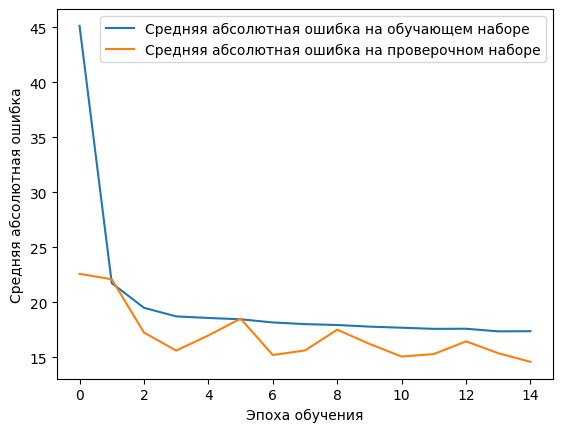

In [17]:
plot_history(history)

Для решения задачи требуются знания по теме `Callbacks`, пожалуйста, изучите раздел:

---
Дополнителная информация: ([База знаний УИИ – **«Callbacks»**](https://colab.research.google.com/drive/1COE1R3kFhRlxPm9X6hQMvjKoiFFt83xW?usp=sharing))

---